In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# **Validation set**

In [ ]:
df_validate = pd.read_csv("/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/validate.csv")
df_validate.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,61.png,1622,626,cam_re,1156,291,1202,329
1,245.png,1622,626,cam_dung_va_do,842,369,850,378
2,245.png,1622,626,cam_con_lai,860,373,868,381
3,261.png,1622,626,cam_re,1156,64,1230,127
4,263.png,1622,626,nguy_hiem,1176,402,1202,422


In [ ]:
df_validate['area'] = (df_validate['xmax'] - df_validate['xmin']) *(df_validate['ymax'] - df_validate['ymin'])
df_validate.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,area
0,61.png,1622,626,cam_re,1156,291,1202,329,1748
1,245.png,1622,626,cam_dung_va_do,842,369,850,378,72
2,245.png,1622,626,cam_con_lai,860,373,868,381,64
3,261.png,1622,626,cam_re,1156,64,1230,127,4662
4,263.png,1622,626,nguy_hiem,1176,402,1202,422,520


In [ ]:
len(df_validate)

999

In [ ]:
df_validate = df_validate[df_validate['area']>=40]
len(df_validate)

928

In [ ]:
df_validate.drop(columns = ['area'], inplace = True)
df_validate.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,61.png,1622,626,cam_re,1156,291,1202,329
1,245.png,1622,626,cam_dung_va_do,842,369,850,378
2,245.png,1622,626,cam_con_lai,860,373,868,381
3,261.png,1622,626,cam_re,1156,64,1230,127
4,263.png,1622,626,nguy_hiem,1176,402,1202,422


In [ ]:
len(df_validate)

928

In [ ]:
np.unique(df_validate['filename']).shape

(416,)

In [ ]:
df_validate.to_csv('/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/validate_40.csv', index = False)

# **Training Set**

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/train.csv')
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,3.png,1622,626,cam_dung_va_do,880,333,899,351
1,5.png,1622,626,cam_re,1069,355,1152,438
2,5.png,1622,626,cam_dung_va_do,768,480,777,487
3,6.png,1622,626,nguy_hiem,781,337,798,352
4,16.png,1622,626,cam_dung_va_do,733,352,740,360


In [ ]:
df_train['area'] = (df_train['xmax'] - df_train['xmin'])*(df_train['ymax'] - df_train['ymin'])
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,area
0,3.png,1622,626,cam_dung_va_do,880,333,899,351,342
1,5.png,1622,626,cam_re,1069,355,1152,438,6889
2,5.png,1622,626,cam_dung_va_do,768,480,777,487,63
3,6.png,1622,626,nguy_hiem,781,337,798,352,255
4,16.png,1622,626,cam_dung_va_do,733,352,740,360,56


In [ ]:
len(df_train)

10001

In [ ]:
df_train = df_train[df_train['area'] >= 40]
len(df_train)

9303

In [ ]:
np.unique(df_train['filename']).shape

(3968,)

In [ ]:
df_train.to_csv("/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/train_40.csv", index = False)

# **IoU and Suppression box**

In [ ]:
def IoU(bbox1, bbox2):
  (box1_x1, box1_y1, box1_x2, box1_y2,_) = bbox1
  (box2_x1, box2_y1, box2_x2, box2_y2,_) = bbox2

  xi1 = max(box1_x1, box2_x1)
  yi1 = max(box1_y1, box2_y1)
  xi2 = min(box1_x2, box2_x2)
  yi2 = min(box1_y2, box2_y2)

# Inter section
  inter_height = max(0, yi2 - yi1)
  inter_weight = max(0, xi2 - xi1)

  inter_area = inter_height * inter_weight

  area_box1 = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
  area_box2 = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

  union_area = area_box1 + area_box2 - inter_area

  iou = inter_area / union_area

  return iou

In [ ]:
box1 = (2, 1, 4, 3,3)
box2 = (1, 2, 3, 4,2)

print("iou for intersecting boxes = " + str(IoU(box1, box2)))
assert IoU(box1, box2) < 1, "The intersection area must be always smaller or equal than the union area."
assert np.isclose(IoU(box1, box2), 0.14285714), "Wrong value. Check your implementation. Problem with intersecting boxes"

## Test case 2: boxes do not intersect
box1 = (1,2,3,4,0)
box2 = (5,6,7,8,0)
print("iou for non-intersecting boxes = " + str(IoU(box1,box2)))
assert IoU(box1, box2) == 0, "Intersection must be 0"

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2,0)
box2 = (2,2,3,3,0)
print("iou for boxes that only touch at vertices = " + str(IoU(box1,box2)))
assert IoU(box1, box2) == 0, "Intersection at vertices must be 0"

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3,0)
box2 = (2,3,3,4,0)
print("iou for boxes that only touch at edges = " + str(IoU(box1,box2)))
assert IoU(box1, box2) == 0, "Intersection at edges must be 0"

print("\033[92m All tests passed!")
# END UNIT TEST

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
 All tests passed!


In [ ]:
def non_max_suppress_box(df):
  images = df['filename'].unique()
  for image in images:
    bboxes = df[df['filename'] == image][['xmin', 'ymin', 'xmax', 'ymax', 'class']].values.tolist()
    for i, box in enumerate(bboxes[:-1]):
      b_class = box[-1]
      for j, remaining_box in enumerate(bboxes[i+1:]):
        iou = IoU(box, remaining_box)
        xmin, ymin, xmax, ymax, rclass = remaining_box
        if (iou > 0.70) & (b_class==rclass):
          index = df[(df['xmin'] == xmin) & (df['xmax'] == xmax) & (df['ymin'] == ymin) & (df['ymax'] == ymax)].index
          df.drop(index, inplace=True)
  return

In [ ]:
df_validate = pd.read_csv("/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/validate_40.csv")

In [ ]:
len(df_validate)

928

In [ ]:
non_max_suppress_box(df_validate)

In [ ]:
len(df_validate)

776

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/train_40.csv")
len(df_train)

9303

In [ ]:
non_max_suppress_box(df_train)

In [ ]:
len(df_train)

7636

In [ ]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,area
0,3.png,1622,626,cam_dung_va_do,880,333,899,351,342
1,5.png,1622,626,cam_re,1069,355,1152,438,6889
2,5.png,1622,626,cam_dung_va_do,768,480,777,487,63
3,6.png,1622,626,nguy_hiem,781,337,798,352,255
4,16.png,1622,626,cam_dung_va_do,733,352,740,360,56


In [ ]:
df_train.to_csv("/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/train_is.csv", index = False)

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/train_is.csv")
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,area
0,3.png,1622,626,cam_dung_va_do,880,333,899,351,342
1,5.png,1622,626,cam_re,1069,355,1152,438,6889
2,5.png,1622,626,cam_dung_va_do,768,480,777,487,63
3,6.png,1622,626,nguy_hiem,781,337,798,352,255
4,16.png,1622,626,cam_dung_va_do,733,352,740,360,56


In [ ]:
len(df)

7636

In [ ]:
df_validate.to_csv("/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/validate_is.csv", index=False)

In [ ]:
df_validate = pd.read_csv("/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/validate_is.csv")

In [ ]:
df_validate.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,61.png,1622,626,cam_re,1156,291,1202,329
1,245.png,1622,626,cam_dung_va_do,842,369,850,378
2,245.png,1622,626,cam_con_lai,860,373,868,381
3,261.png,1622,626,cam_re,1156,64,1230,127
4,263.png,1622,626,nguy_hiem,1176,402,1202,422


In [ ]:
len(df)

776

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib.patches as patches

In [ ]:
def get_all_bboxes(df, filename):
    image_bboxes = df[df.filename == filename]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.xmin, row.ymin, row.xmax, row.ymax))
        
    return bboxes

In [ ]:
df_classic = pd.read_csv("/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/train_40.csv")

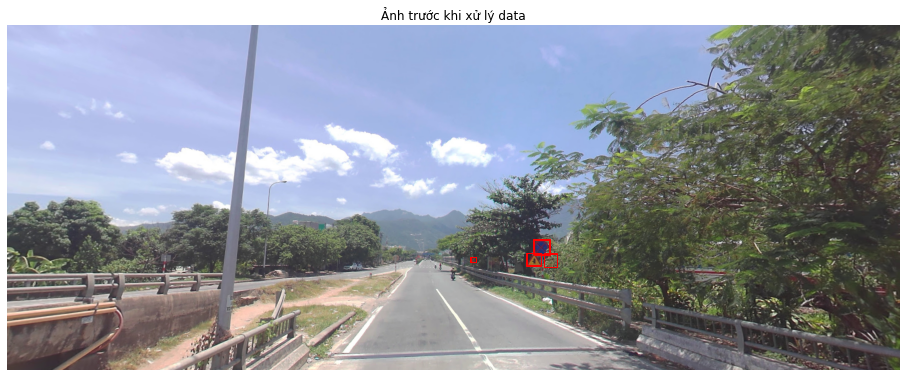

In [ ]:
train_path = '/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/images'
fig, axs = plt.subplots(1,1, figsize=(16,8))
img_id = '8794.png'
img = cv2.imread(os.path.join(train_path, img_id))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
axs.imshow(img)


bboxes = get_all_bboxes(df_classic, img_id)
for bbox in bboxes:
  rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
  axs.add_patch(rect)
axs.axis('off')
plt.title('Ảnh trước khi xử lý data')
plt.show()

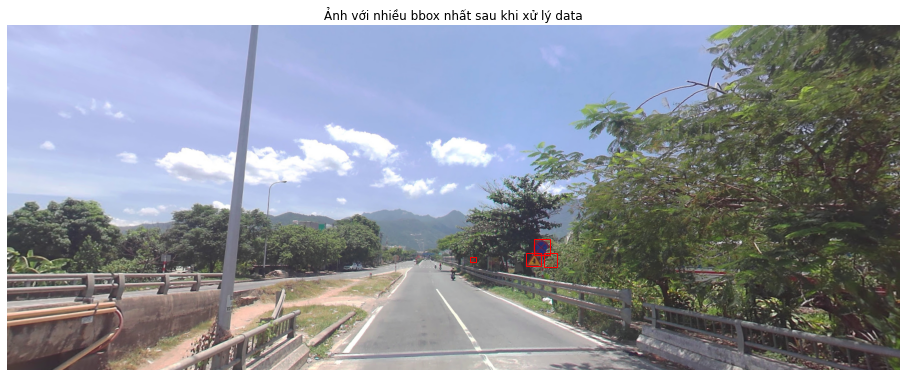

In [ ]:
train_path = '/content/drive/MyDrive/TrafficSignDetection/Dataset/traffic_train/images'
fig, axs = plt.subplots(1,1, figsize=(16,8))
img_id = '8794.png'
img = cv2.imread(os.path.join(train_path, img_id))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
axs.imshow(img)
            
bboxes = get_all_bboxes(df_train, img_id)
for bbox in bboxes:
  rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
  axs.add_patch(rect)
axs.axis('off')
plt.title('Ảnh sau khi xử lý data')
plt.show()